# Analysis of "House Rocket" dataset

### In this section we will explorate the House Rocket dataset. We will follow the following steps:

1. Identify the duplicated or missing values from the dataset and treat the them if necessary.
2. Calculate descriptive statistics of the dataset.
3. Identify outliers on the dataset and treat them if necessary.
4. Identify the correlation between the houses features and the house price.

In [1]:
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from notebooks.get_local_folder import get_local_folder

In [11]:
# Load data
abs_path_to_folder = get_local_folder()
dataset_path = os.path.join(abs_path_to_folder, "../data/cleaned/houses_data.parquet")
houses = pd.read_parquet(dataset_path)

# Data Exploratory
In this section we will explorate the House Rocket dataset. We will follow the following steps:


## Calculating Desciptive Statistics
We'll start with calculating some descriptive statistics about the House Rocket prices and plot a distribuition graphic of price.

In [12]:
# Descriptive statistics
def descriptive_statistics(data, column):
    descriptive_statistics_df = data[column].describe()

    print('Avarage Price: {:,.2f}'.format(descriptive_statistics_df.iloc[1]))
    print('Median Price: {:,.2f}'.format(descriptive_statistics_df.iloc[5]))
    print('Minimun Price: {:,.2f}'.format(descriptive_statistics_df.iloc[3]))
    print('Maximun Price: {:,.2f}'.format(descriptive_statistics_df.iloc[7]))
    print('The std Price: {:,.2f}'.format(descriptive_statistics_df.iloc[2]))


descriptive_statistics(houses, 'Price')

Avarage Price: 540,088.14
Median Price: 450,000.00
Minimun Price: 75,000.00
Maximun Price: 7,700,000.00
The std Price: 367,127.20


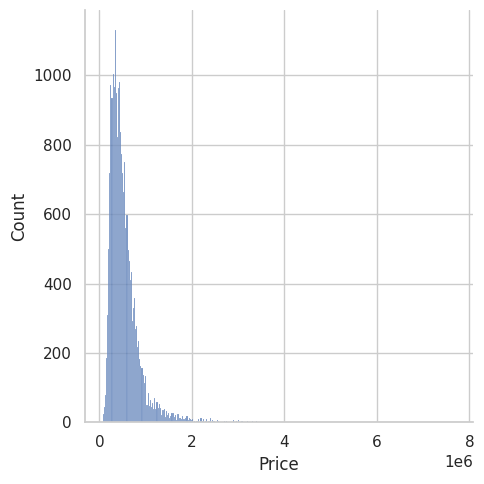

In [17]:
# Distribution Graphic of Price
sns.displot(houses['Price'])

plt.savefig(os.path.join(abs_path_to_folder, "../reports/figures/price_distribution_with_outliers.png")) # Save graphic
plt.show()

### Observarions
After observing the price statistics, the difference between the Average Price and the Maximum Price is big. The graph shows us how abnormal the price distribution is, this would mean that there may be outlier houses in the data set, or in other words, houses with prices much above the average that can distort the result of the exploratory analysis, so we'll identify these outliers and create a new dataset without them.

## Treating Outliers
I will use the "Inter Quartile Range" (IQR) method to find the outliers, then plot two Box Plot type graphs comparing the price dispersion before and after removing the outliers.

### Inter Quartile Range (IQR) Method
In the "IQR" method, we will find the lower and upper price limit values ​​through operations with the quartiles, everything outside these limits will be considered an outlier.

First we need to define what a quartile is. According to Wikipedia:

"A quartile is any one of three values ​​that divides the ordered set of data into four equal parts, so each part represents 1/4 of the sample or population.

So, in the case of an ordered sample:

* First quartile (referred to as Q1/4) = lower quartile = is the value at 25% of the ordered sample = 25th percentile
* Second quartile (referred to as Q2/4) = median = the value up to which 50% of the ordered sample is found = 50th percentile, or 50th decile.
* Third quartile (referred to as Q3/4) = upper quartile = value from which 25% of the highest values ​​are found = value at 75% of the ordered sample = 75th percentile"

#### To find the lower and upper limit of prices, we need to carry out trades with Quartiles.

1- We need to find the Inter Quartil Range (IQR). For this we need to subtract the 3rd quartile from the 1st quartile.

2- To find the upper limit, we need to add to the 3rd quartile the multiplication of the IQR by 1.5.

3- To find the lower limit, we need to subtract from the 1st quartile the multiplication of the IQR by 1.5.

In [14]:
def outliers_iqr(df: pd.DataFrame, column: str, upper: float = 1.0, lower: int = 1.0, return_type: str = 'limits'):
    """Calculate the Upper and Lower Limit through the IQR method for find 'Outliers'.
    
    Args:
        data (pandas.DataFrame): Pandas DataFrame.
        colunm (str): Column name.
        upper (float, optional): Percentage of the upper limit to be considered outlier. Default is 1.0.
        lower (float, optional): Percentage of the lower limit to be considered outlier. Default it 1.0.
        return_type (str, optional): What the function should return. Can be 'limits' or 'dataframe'.

    Returns:
        (int, int) or pandas.DataFrame: Value of the Upper Limit and Lower Limit, respectivily, or the DataFrame without outliers.
    """
    import numpy as np

    quartile_1, quartile_3 = np.percentile(df[column], [25, 75])
    iqr = quartile_3 - quartile_1
    lower_limit = (quartile_1 - (iqr * 1.5)) * lower
    upper_limit = (quartile_3 + (iqr * 1.5)) * upper

    df_without_outliers = df.loc[(df[column] <= upper_limit)
                          & (df[column] >= lower_limit)]
    print('Lower Bound: {:,.2f} '.format(lower_limit))
    print('Upper Bound: {:,.2f}'.format(upper_limit))
    print('{} lines with outliers were identified, corresponding to {:.2f}% of the dataset.'.format(
        (df.shape[0] - df_without_outliers.shape[0]),
        ((df.shape[0] - df_without_outliers.shape[0]) * 100) / df.shape[0]))

    if return_type == 'limits':
        return upper_limit, lower_limit
    elif return_type == 'dataframe':
        return df_without_outliers
    else:
        return print("""Unexpected return value. 
Available values: 'limits','dataframe'.
Nothing has returned""")


# Inter Quartile Range (IQR) Method Function
upper_limit, lower_limit = outliers_iqr(df=houses, column='Price')

Lower Bound: -162,625.00 
Upper Bound: 1,129,575.00
1146 lines with outliers were identified, corresponding to 5.30% of the dataset.


Now we see that 5.30% of the dataset was considered an outlier, but deleting this large amount of data would result in loss of information. So, let's pass a parameter where only values ​​above 150% of the maximum limit are considered an outliers and return a DataFrame.

In [15]:
houses_without_outliers = outliers_iqr(df=houses, column='Price', upper=1.5, return_type='dataframe')

Lower Bound: -162,625.00 
Upper Bound: 1,694,362.50
366 lines with outliers were identified, corresponding to 1.69% of the dataset.


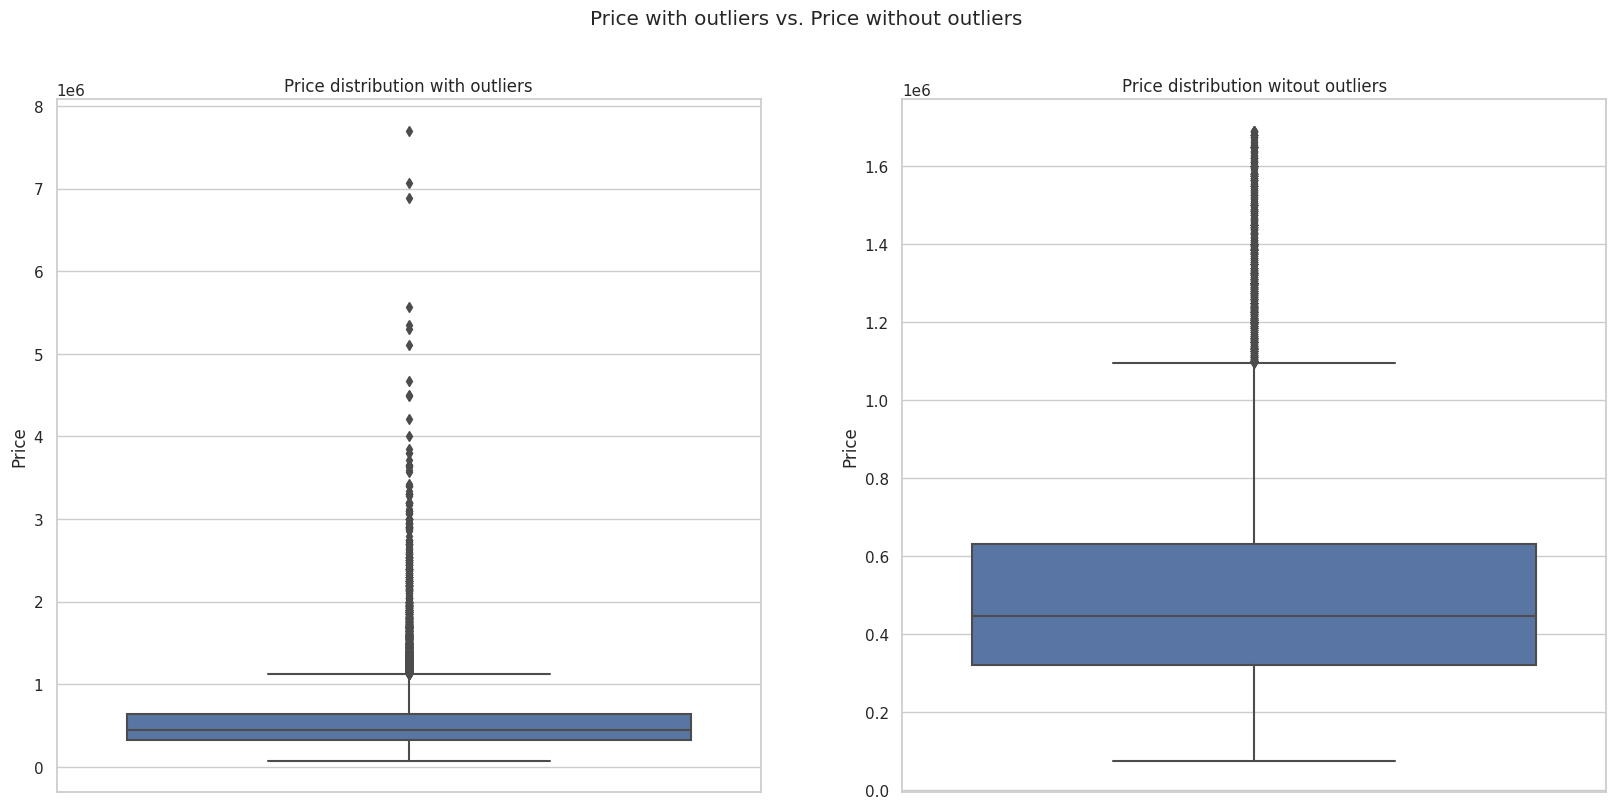

In [16]:
# Box Plot graphics comparassing with dataset with outliers and without outliers
fig, axes = plt.subplots(1, 2, figsize=(20,9), sharex=True)
fig.suptitle('Price with outliers vs. Price without outliers')
sns.set_theme(style="whitegrid")

# Price with outliers
sns.boxplot( ax=axes[0], y=houses['Price'] )
axes[0].set_title('Price distribution with outliers')

# Price without outliers
sns.boxplot(ax=axes[1], y=houses_without_outliers['Price'])
axes[1].set_title('Price distribution witout outliers')

plt.savefig(os.path.join(abs_path_to_folder, "../reports/figures/price_comparison_with_and_without_outliers.png")) # Save graphic

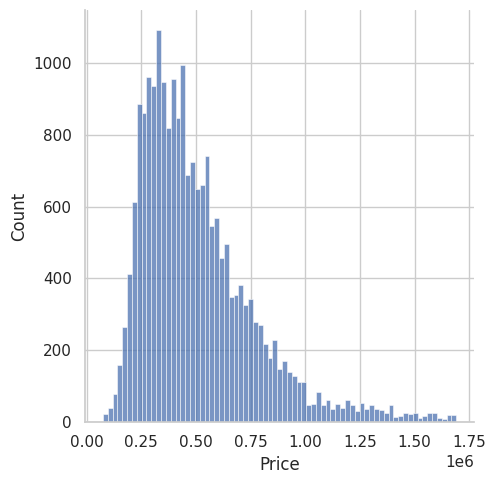

In [18]:
# Distribution Graphic 
sns.displot(houses_without_outliers['Price'])

plt.savefig(os.path.join(abs_path_to_folder, "../reports/figures/price_distribution_without_outliers.png")) #Save Graphic
plt.show()

After comparing the two graphs and the distribution graphic, the difference between the price distribution in the dataset with outliers and without outliers is visible, but analyzing the data without outliers can result in loss of information, keep that in mind.

In [20]:
houses_without_outliers.to_parquet(os.path.join(abs_path_to_folder, "../data/without_outliers/houses_without_outliers.parquet")) # Save dataset without outliers
houses = houses_without_outliers.copy()

## Correlation of price with Variables
Now let's look at the correlation between price and other variables in the dataset. That way we can identify the variables with the most correlation with the price.

/tmp/ipykernel_655/4257555122.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = houses.corr()


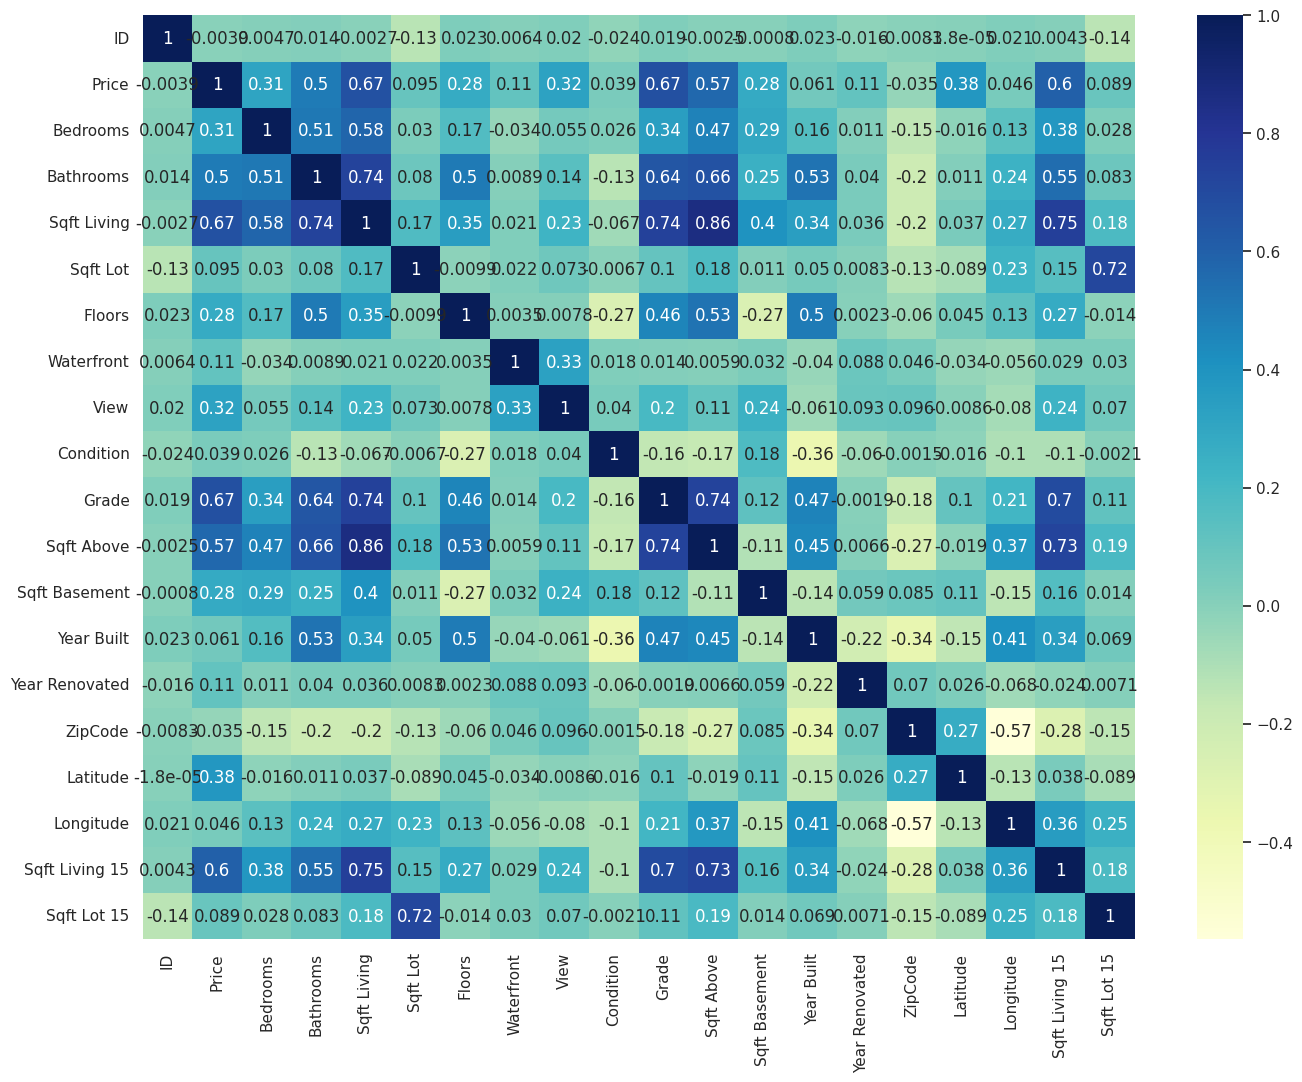

In [21]:
# Plot a HeatMap with correlation
corr = houses.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, xticklabels=True, yticklabels=True, cmap="YlGnBu")

plt.savefig(os.path.join(abs_path_to_folder, "../reports/figures/price_heatmap_correlation.png")) # Save graphic
plt.show()

Correlation of each variable with the price

In [31]:
corr['Price'].sort_values(ascending=False).iloc[1:].reset_index()

,index,Price
0,Grade,0.673951
1,Sqft Living,0.669080
2,Sqft Living 15,0.598269
3,Sqft Above,0.570982
4,Bathrooms,0.497622
5,Latitude,0.381467
6,View,0.324330
7,Bedrooms,0.313093
8,Sqft Basement,0.282128
9,Floors,0.277596


Based on the Graphic and table above, the variables "Grade" and "Sqft Living" are the most correlated with price.

- "Grade" represents the quality of the house's construction materials, ranging from 1 to 13.
- "Sqft Living" is the number of square feet of the house itself.

Now let's see the correlation of the price with "Grade" and "Sqft Living" specifically.

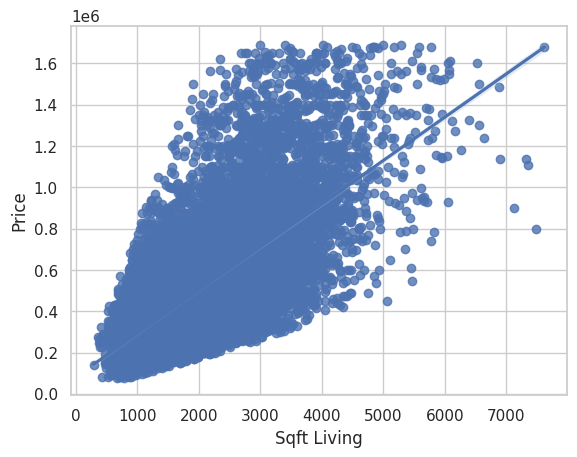

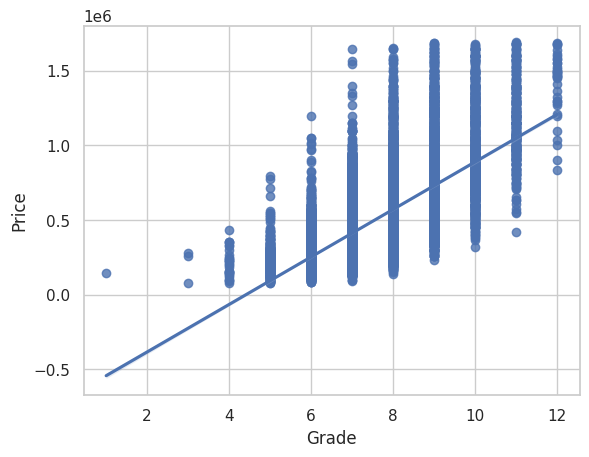

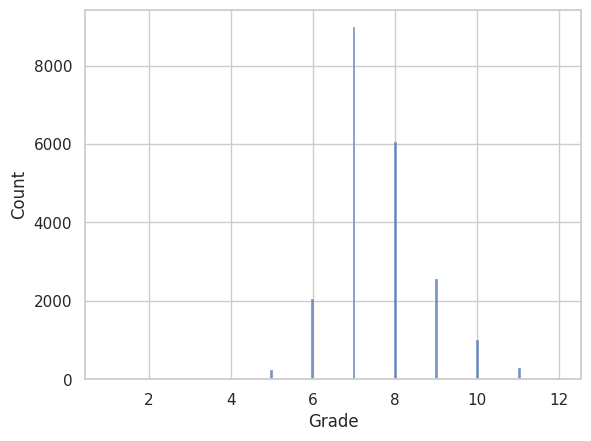

In [26]:
# Plot graphs with the correlation between price and other variables
cont = 0
for var in ['Sqft Living','Grade','Grade']:
    cont += 1
    if cont < 3:
        sns.regplot(x=houses[var], y=houses['Price'])
        plt.show()
    else:
        sns.histplot(houses[var])

Looking specifically at the first chart we can see that after 2,000 square feet the **maximum** price of the houses normalizes, but the **minimum** price keeps rising from the start, making the positive correlation between price and square foot even more visible.

Looking at the second graph we see that the maximum price rises according to the quality of the house's materials, and in the last graph we can see that there is a large concentration of houses with the same grade, so let's see what this grade is and the average price of each note.

### Number of houses per Grade

In [29]:
houses['Grade'].value_counts().reset_index()

,index,Grade
0,7,8980
1,8,6053
2,9,2562
3,6,2038
4,10,1008
5,11,294
6,5,242
7,12,37
8,4,29
9,3,3


### Avarage price of the houses per Grade

In [54]:
grade_prices = houses[['Price','Grade']].groupby('Grade').mean()
grade_prices = pd.DataFrame(grade_prices['Price'].map(lambda x: '%.2f' % x)).reset_index()
grade_prices

,Grade,Price
0,1,142000.00
1,3,205666.67
2,4,214381.03
3,5,248523.97
4,6,301919.64
5,7,402406.81
6,8,539073.45
7,9,748263.85
8,10,938168.83
9,11,1160921.94


In [53]:
grades_number = pd.DataFrame(houses['Grade'].value_counts()).reset_index()
grades_number = grades_number.rename(columns={"index": "Grade", "Grade": "Count"})
grade_prices = houses[['Price','Grade']].groupby('Grade').mean()
grade_prices = pd.DataFrame(grade_prices['Price'].map(lambda x: '%.2f' % x)).reset_index()

grades_sts = pd.merge(grade_prices, grades_number, on="Grade")
grades_sts

,Grade,Price,Count
0,1,142000.00,1
1,3,205666.67,3
2,4,214381.03,29
3,5,248523.97,242
4,6,301919.64,2038
5,7,402406.81,8980
6,8,539073.45,6053
7,9,748263.85,2562
8,10,938168.83,1008
9,11,1160921.94,294


Based on the table above, we observe that a large number of houses have a 7 or 8 grade, and each grade has an average price of 402,406.81 and 539,073.45, respectively.

In my option, the houses with grade 8 or higher have the best average price by rating and number of houses.

# Final Observations

1. The dataset has a large amount of outliers identified by the Inter Quartitle Range method, approximately 5.30%, but we consider only 1.69% of the dataset as outliers.
2. The variables with the highest positive correlation with price are "Grade" and "Sqft living".
3. Houses rated 8 or higher in the "Grade" attribute have the best average price per rank and number of homes.